In [1]:
%matplotlib inline
import librosa, numpy, scipy.linalg, IPython.display as ipd, matplotlib.pyplot as plt
import librosa.display

[&larr; Back to Index](index.html)

# NMF Audio Mosaicing

This notebook is inspired by [the work of Jonathan Driedger, Thomas Prätzlich, and Meinard Müller](https://www.audiolabs-erlangen.de/resources/MIR/2015-ISMIR-LetItBee).

Here is a fun exercise to understand how NMF works. We are going to synthesize an audio signal, $y$, using spectral content from one audio signal, $x_1$, and the NMF temporal activations from another audio signal, $x_2$.

Step 1: Compute the STFT of the first signal, $x_1$:

$$ X_1 \leftarrow \textrm{STFT}(x_1) $$

Step 2: Perform NMF on the second signal, $x_2$, to learn temporal activations while *fixing* the spectral profiles to the magnitude spectrogram, $|X_1|$, learned in step 1:

$$ H \leftarrow \textrm{NMF}(x_2, |X_1|) $$

Step 3: Synthesize an audio signal using $|X_1|$ and $H$:

$$ y \leftarrow \textrm{ISTFT}(|X_1| H) $$

## Step 1: Magnitude Spectrogram of Signal 1

Load the first signal, $x_1$:

In [3]:
!ls audio

125_bounce.wav			c_strum.wav	  simple_piano.wav
58bpm.wav			drum_samples	  sir_duke_piano_fast.mp3
brahms_hungarian_dance_5.mp3	funk_groove.mp3   sir_duke_piano_slow.mp3
busta_rhymes_hits_for_days.mp3	jangle_pop.mp3	  sir_duke_trumpet_fast.mp3
clarinet_c6.wav			latin_groove.mp3  sir_duke_trumpet_slow.mp3
classic_rock_beat.mp3		oboe_c6.wav	  thx_original.mp3
classic_rock_beat.wav		prelude_cmaj.wav  tone_440.wav
conga_groove.wav		README.md
cowbell.wav			simple_loop.wav


In [6]:
!play audio/simple_piano.wav


audio/simple_piano.wav:

 File Size: 170k      Bit Rate: 353k
  Encoding: Signed PCM    
  Channels: 1 @ 16-bit   
Samplerate: 22050Hz      
Replaygain: off         
  Duration: 00:00:03.85  

In:100%  00:00:03.85 [00:00:00.00] Out:84.9k [   -==|==-   ] Hd:0.0 Clip:0    
Done.


In [18]:
x1, sr = librosa.load('audio/latin_groove.mp3')

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [19]:
ipd.Audio(x1, rate=sr)

Compute STFT $X_1$, and separate into magnitude and phase:

In [20]:
X1 = librosa.stft(x1)
X1_mag, X1_phase = librosa.magphase(X1)

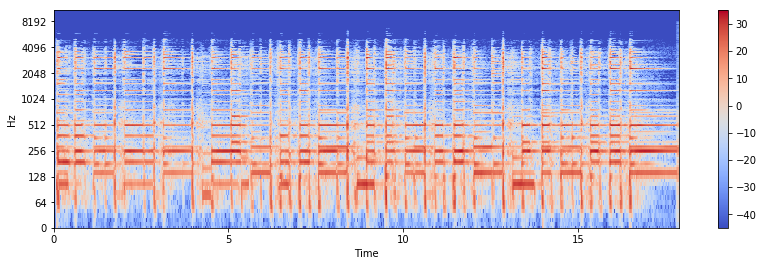

In [21]:
X1_db = librosa.amplitude_to_db(X1_mag)
plt.figure(figsize=(14, 4))
librosa.display.specshow(X1_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

## Step 2: NMF on Signal 2

Load the second signal, $x_2$:

In [13]:
x2, _ = librosa.load('audio/funk_groove.mp3')

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [14]:
ipd.Audio(x2, rate=sr)

Compute STFT $X_2$, and separate into magnitude and phase:

In [15]:
X2 = librosa.stft(x2)
X2_mag, X2_phase = librosa.magphase(X2)

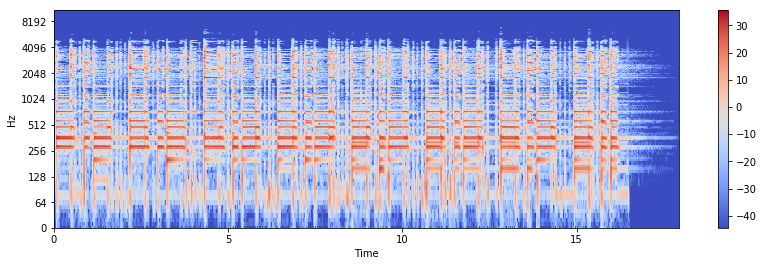

In [16]:
X2_db = librosa.amplitude_to_db(X2_mag)
plt.figure(figsize=(14, 4))
librosa.display.specshow(X2_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

Define $W \triangleq |X_1|$. $W$ will remain fixed.

Perform NMF, but we will only apply an update to $H$, not $W$:

$$ H \leftarrow H \frac{W^T |X_2|}{W^T W H} $$

For this, we will write our own multiplicative update rule that only updates $H$:

We can say that we're looking for an H here that (when multiplied to W) "pulls" W (w/c is the spectral component of X1) to the "space" of X2.

In [32]:
eps = 0.01
h = numpy.random.rand(1,1)
w = numpy.array([[3]])
x2 = numpy.array([[4]])

print(h)
wtx = w.T.dot(x2)
wtw = w.T.dot(w)

print(wtx, wtw)

for _ in range(100):
    h = h*(wtx+eps)/(wtw.dot(h) + eps)
    
print(h)

[[0.86126038]]
[[12]] [[9]]
[[1.33333333]]


In [45]:
# Cache some matrix multiplications.
W = librosa.util.normalize(X1_mag, norm=2, axis=0)
WTX = W.T.dot(X2_mag)
WTW = W.T.dot(W)

# Initialize H.
H = numpy.random.rand(X1.shape[1], X2.shape[1])
H_rand = H.copy()

# Update H.
eps = 0.01
for _ in range(100):
    H = H*(WTX + eps)/(WTW.dot(H) + eps)

In [46]:
numpy.sum(abs(X2_mag - (W.dot(H_rand))))

2144519.269704901

In [47]:
numpy.sum(abs(X2_mag - (W.dot(H))))

306596.8951935527

In [29]:
W.shape

(1025, 770)

In [27]:
H.shape

(770, 772)

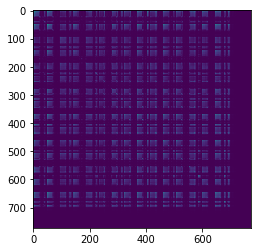

In [48]:
plt.imshow(H.T.dot(H))

## Step 3: Synthesize Output Signal

Synthesize the output signal, $y$, from the spectral components of $x_1$ and the temporal activations (and phase) of $x_2$:

In [57]:
Y_mag = W.dot(H)

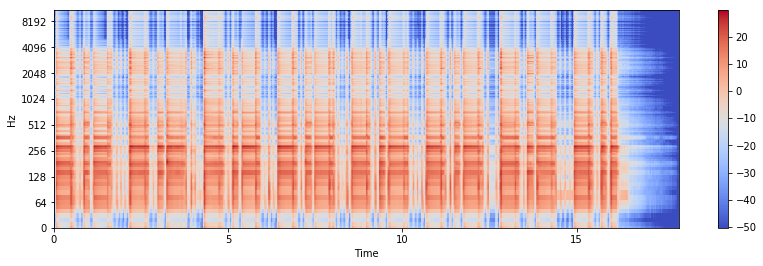

In [58]:
Y_db = librosa.amplitude_to_db(Y_mag)
plt.figure(figsize=(14, 4))
librosa.display.specshow(Y_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [59]:
Y = Y_mag*X2_phase
y = librosa.istft(Y)

In [60]:
ipd.Audio(y, rate=sr)

#### Using librosa NMF

In [88]:
W1, H1 = librosa.decompose.decompose(X1_mag, n_components=6)
print(W1.shape, H1.shape)

(1025, 6) (6, 770)


In [89]:
y1 = librosa.istft(W1.dot(H1)*X1_phase)
ipd.Audio(y1, rate=sr)

In [90]:
W2, H2 = librosa.decompose.decompose(X2_mag, n_components=6)
print(W2.shape, H2.shape)

(1025, 6) (6, 772)


In [91]:
y2 = librosa.istft(W2.dot(H2)*X2_phase)
ipd.Audio(y2, rate=sr)

In [105]:
# Latin spectra, Funky activations/temporal envelope + phase
y3 = librosa.istft(W1.dot(H2)*X2_phase)
ipd.Audio(y3, rate=sr)

In [106]:
# Funky spectra, Latin activations/temporal envelope + phase
y4 = librosa.istft(W2.dot(H1)*X1_phase)
ipd.Audio(y4, rate=sr)

# interesting.. i can hear some funky timbre but the rhythm is latin

## Alternate Approach: Sparse Coding

In [97]:
from sklearn.decomposition import SparseCoder

In [98]:
sparse_coder = SparseCoder(X1_mag.T, transform_n_nonzero_coefs=1)

In [99]:
H = sparse_coder.transform(X2_mag.T)

In [100]:
H.shape

(772, 770)

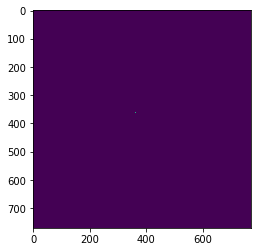

In [101]:
plt.imshow(H.T.dot(H))

In [107]:
Y_mag = W.dot(H.T)

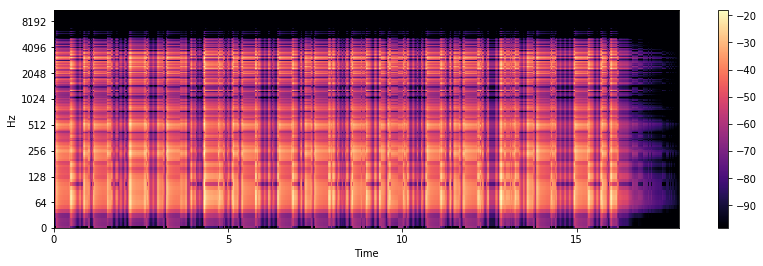

In [108]:
Y_db = librosa.amplitude_to_db(Y_mag)
plt.figure(figsize=(14, 4))
librosa.display.specshow(Y_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [109]:
Y = Y_mag*X2_phase
y = librosa.istft(Y)

In [110]:
ipd.Audio(y, rate=sr)

# ???

[&larr; Back to Index](index.html)